In [3]:
import numpy as np
import torch
from einops import rearrange
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

from diffusion_3d.chestct.autoencoder.nvae.cnn.config import get_config
from diffusion_3d.chestct.autoencoder.nvae.cnn.model import NVAELightning
from diffusion_3d.datasets.ct_rate import CTRATEDataModule
from arjcode.visualize import plot_scans

In [4]:
config = get_config()
config

Munch({'data': Munch({'csvpath': '/raid3/arjun/ct_pretraining/csvs/sources.csv', 'datapath': '/raid3/arjun/ct_pretraining/scans/', 'checkpointspath': '/raid3/arjun/checkpoints/adaptive_autoencoder/', 'limited_dataset_size': None, 'allowed_spacings': ((0.4, 7), (-1, -1), (-1, -1)), 'allowed_shapes': ((64, -1), (256, -1), (256, -1)), 'train_augmentations': Munch({'_target_': 'monai.transforms.Compose', 'transforms': [Munch({'_target_': 'vision_architectures.transforms.croppad.CropForegroundWithCropTrackingd', 'keys': ['image'], 'source_key': 'image', 'allow_smaller': True}), Munch({'_target_': 'monai.transforms.ScaleIntensityRanged', 'keys': ['image'], 'a_min': -1000, 'a_max': 2000, 'b_min': -1.0, 'b_max': 1.0, 'clip': True}), Munch({'_target_': 'vision_architectures.transforms.croppad.RandSpatialCropSamplesWithCropTrackingd', 'keys': ['image'], 'roi_size': (51, 102, 102), 'max_roi_size': (76, 153, 153), 'random_size': True, 'num_samples': 5}), Munch({'_target_': 'vision_architectures.tr

In [5]:
checkpoint_path = r"/raid3/arjun/checkpoints/adaptive_autoencoder/v57__2025_04_07/version_0/checkpoints/last.ckpt"

model = NVAELightning.load_from_checkpoint(
    checkpoint_path,
    map_location="cpu",
    model_config=config.model,
    training_config=config.training,
)
model.eval()
# model.cuda()

/home/users/arjun.agarwal/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/users/arjun.agarwal/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



NVAELightning(
  (autoencoder): NVAE(
    (encoder_mapping): CNNBlock3D(
      (conv): Conv3d(1, 12, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
      (checkpointing_level1): ActivationCheckpointing(enabled=False)
    )
    (encoder): Encoder(
      (stages): ModuleList(
        (0): Sequential(
          (0): StageBlock(
            (layers): Sequential(
              (0): ResBlock(
                (conv1): CNNBlock3D(
                  (conv): Conv3d(12, 12, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
                  (norm): GroupNorm(6, 12, eps=1e-05, affine=True)
                  (act): SiLU()
                  (checkpointing_level1): ActivationCheckpointing(enabled=False)
                )
                (conv2): CNNBlock3D(
                  (conv): Conv3d(12, 12, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
                  (norm): GroupNorm(6, 12, eps=1e-05, affine=True)
                  (act): SiLU()
                  (checkpointing_level

In [6]:
datamodule = CTRATEDataModule(config.data)
dataloader = datamodule.test_dataloader()
len(dataloader)

test: 100%|██████████| 500/500 [00:01<00:00, 352.08it/s]

No. of test datapoints: 500


25

In [ ]:
with torch.no_grad():
    for i, batch in enumerate(dataloader):
        if i >= 1:
            break

        x = batch["image"][:2]
        crop_offsets = batch['crop_offset'][:4]

        reconstructed = model(x.to(model.device))["reconstructed"].cpu()
        print(f"Batch idx: {i}")
        print(x.shape, reconstructed.shape)
        print((x.min(), x.max()), (reconstructed.min(), reconstructed.max()))

        x[:, :, :, 0, 0] = -1.0
        x[:, :, :, -1, -1] = 1.0
        reconstructed[:, :, :, 0, 0] = -1.0
        reconstructed[:, :, :, -1, -1] = 1.0

        for i in range(x.shape[0]):
            plot_scans([x[i][0], reconstructed[i][0]], ["Original", "Reconstructed"])

torch.cuda.empty_cache()

Batch idx: 0
torch.Size([4, 1, 64, 128, 128]) torch.Size([4, 1, 64, 128, 128])
(metatensor(-1.), metatensor(0.9627)) (metatensor(-1.), metatensor(0.6608))


interactive(children=(IntSlider(value=0, description='z', max=63), Output()), _dom_classes=('widget-interact',…

interactive(children=(IntSlider(value=0, description='z', max=63), Output()), _dom_classes=('widget-interact',…

interactive(children=(IntSlider(value=0, description='z', max=63), Output()), _dom_classes=('widget-interact',…

interactive(children=(IntSlider(value=0, description='z', max=63), Output()), _dom_classes=('widget-interact',…

# KL per dim

In [6]:
raise Exception("Don't want to automatically run beyond this point")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 raise Exception("Don't want to automatically run beyond this point")                         │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
Exception: Don't want to automatically run beyond this point

In [ ]:
priors = []
posteriors = []

with torch.no_grad():
    for i, batch in enumerate(tqdm(dataloader)):
        if i > 25:
            break

        x = batch["image"]

        output = model(x.to(model.device))

        def cpu(output):
            for i in range(len(output)):
                if output[i][0] is None:
                    continue
                output[i] = (output[i][0].cpu(), output[i][1].cpu())
            return output

        priors.append(cpu(output['prior_distributions']))
        posteriors.append(cpu(output['posterior_distributions']))

torch.cuda.empty_cache()

Error in callback <bound method AutoreloadMagics.pre_run_cell of <IPython.extensions.autoreload.AutoreloadMagics object at 0x7f4b2dec1c30>> (for pre_run_cell):


torch.Size([24, 4, 8, 8])


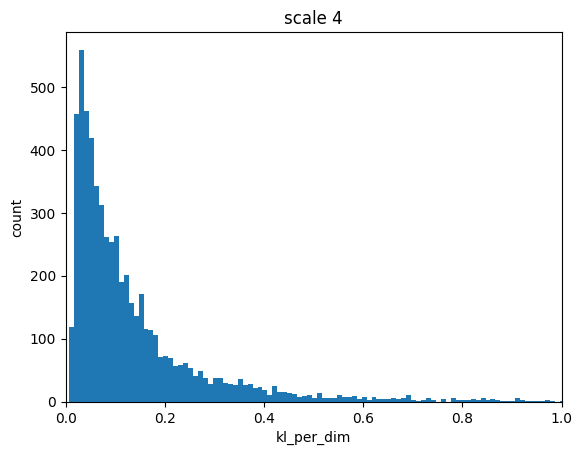

In [ ]:
priors4 = [p[4] for p in priors]
posteriors4 = [p[4] for p in posteriors]

kl_per_dim = []
for prior, posterior in zip(priors4, posteriors4):
    kl_per_dim.append(model.autoencoder.decoder.latent_space_ops.latent_space.kl_divergence(posterior[0], posterior[1], prior[0], prior[1], reduction=None))

kl_per_dim = torch.cat(kl_per_dim, dim=0)
kl_per_dim = kl_per_dim.sum(dim=0)
print(kl_per_dim.shape)

%matplotlib inline
from matplotlib import pyplot as plt
plt.xlim(0, 1)
plt.xlabel('kl_per_dim')
plt.ylabel('count')
plt.hist(kl_per_dim.cpu().clamp(max=10).numpy().flatten(), bins=1000)
plt.title('scale 4')
plt.show()

torch.Size([12, 8, 16, 16])


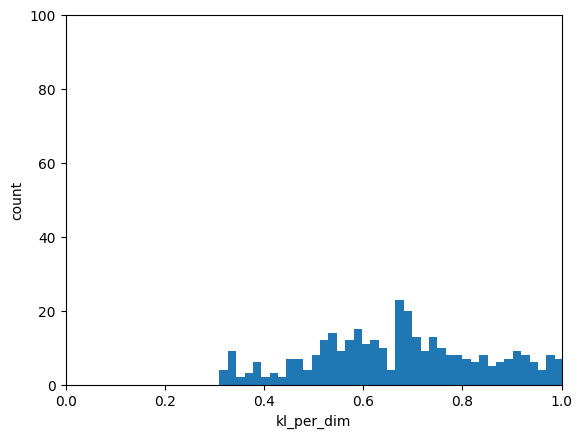

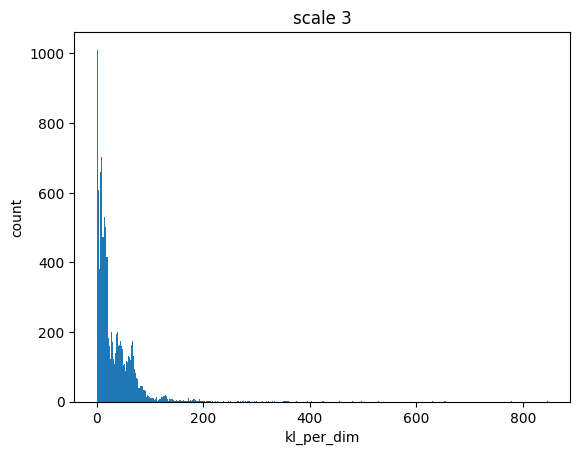

In [ ]:
priors3 = [p[3] for p in priors]
posteriors3 = [p[3] for p in posteriors]

kl_per_dim = []
for prior, posterior in zip(priors3, posteriors3):
    kl_per_dim.append(model.autoencoder.decoder.latent_space_ops.latent_space.kl_divergence(posterior[0], posterior[1], prior[0], prior[1], reduction=None))

kl_per_dim = torch.cat(kl_per_dim, dim=0)
kl_per_dim = kl_per_dim.sum(dim=0)
print(kl_per_dim.shape)

%matplotlib inline
from matplotlib import pyplot as plt
plt.xlim(0, 1)
plt.ylim(0, 100)
plt.xlabel('kl_per_dim')
plt.ylabel('count')
plt.hist(kl_per_dim.cpu().clamp(max=2).numpy().flatten(), bins=100)
plt.show()

# plt.xlim(0, 100)
plt.xlabel('kl_per_dim')
plt.ylabel('count')
plt.hist(kl_per_dim.cpu().numpy().flatten(), bins=1000)
plt.title('scale 3')
plt.show()

torch.Size([6, 16, 32, 32])


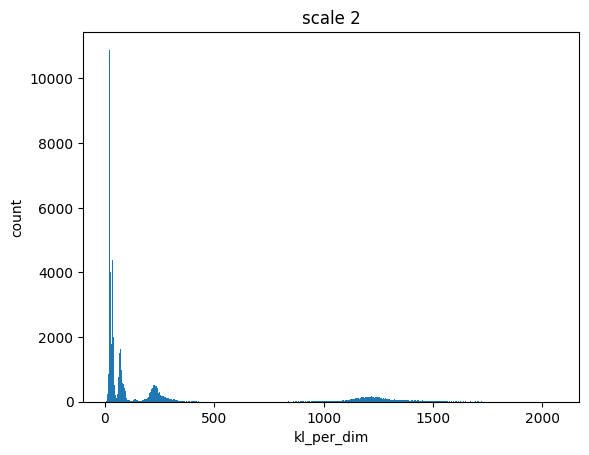

In [ ]:
priors2 = [p[2] for p in priors]
posteriors2 = [p[2] for p in posteriors]

kl_per_dim = []
for prior, posterior in zip(priors2, posteriors2):
    kl_per_dim.append(model.autoencoder.decoder.latent_space_ops.latent_space.kl_divergence(posterior[0], posterior[1], prior[0], prior[1], reduction=None))

kl_per_dim = torch.cat(kl_per_dim, dim=0)
kl_per_dim = kl_per_dim.sum(dim=0)
print(kl_per_dim.shape)

%matplotlib inline
from matplotlib import pyplot as plt

# plt.xlim(0, 500)
plt.xlabel('kl_per_dim')
plt.ylabel('count')
plt.hist(kl_per_dim.cpu().numpy().flatten(), bins=1000)
plt.title('scale 2')
plt.show()

# PCA

In [ ]:
raise Exception("Don't want to automatically run beyond this point")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 raise Exception("Don't want to automatically run beyond this point")                         │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
Exception: Don't want to automatically run beyond this point

In [ ]:
import gc
from collections import defaultdict

device = torch.device("cuda:0")

latent_vectors = []
stage_output_vectors = defaultdict(list)

model.to(device)

with torch.no_grad():
    for batch in tqdm(dataloader):
        x = batch["image"].to(device)
        mu, _, stage_outputs = model.encode(x, return_stage_outputs=True)
        x.cpu()
        del x
        latent_vectors.append(mu.cpu().numpy())
        for i in range(len(stage_outputs)):
            stage_output_vectors[i].append(stage_outputs[i].cpu().numpy())

gc.collect()
torch.cuda.empty_cache()

latent_vectors = np.concatenate(latent_vectors, axis=0)

  0%|          | 0/500 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:14                                                                                   │
│                                                                                                  │
│   11 with torch.no_grad():                                                                       │
│   12 │   for batch in tqdm(dataloader):                                                          │
│   13 │   │   x = batch["image"].to(device)                                                       │
│ ❱ 14 │   │   mu, _, stage_outputs = model.encode(x, return_stage_outputs=True)                   │
│   15 │   │   x.cpu()                                                                             │
│   16 │   │   del x                                                                               │
│   17 │   │   latent_vectors.append(mu.cpu().numpy())                                             │
│                                                                                                  │
│ /home/ubuntu/projects/diffusion_3d/src/diffusion_3d/chestct/autoencoder/vae/nn.py:212 in encode  │
│                                                                                                  │
│   209 │   │   #     sliding_window = 2**14                                                       │
│   210 │   │   #     sliding_stride = sliding_window // 2                                         │
│   211 │   │                                                                                      │
│ ❱ 212 │   │   adapted = self.adapt(                                                              │
│   213 │   │   │   list(reversed(stage_outputs)),  # Show low frequency features first, then sh   │
│   214 │   │   │   sliding_window=sliding_window,                                                 │
│   215 │   │   │   sliding_stride=sliding_stride,                                                 │
│                                                                                                  │
│ /home/ubuntu/miniconda3/lib/python3.10/site-packages/torch/nn/modules/module.py:1931 in          │
│ __getattr__                                                                                      │
│                                                                                                  │
│   1928 │   │   │   modules = self.__dict__["_modules"]                                           │
│   1929 │   │   │   if name in modules:                                                           │
│   1930 │   │   │   │   return modules[name]                                                      │
│ ❱ 1931 │   │   raise AttributeError(                                                             │
│   1932 │   │   │   f"'{type(self).__name__}' object has no attribute '{name}'"                   │
│   1933 │   │   )                                                                                 │
│   1934                                                                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'AdaptiveVAE' object has no attribute 'adapt'

In [ ]:
pattern = "b c z y x -> (b z y x) c"
# pattern = "b c z y x -> b (c z y x)"

latent_vectors_rearranged = rearrange(latent_vectors, pattern)
for i in range(len(stage_output_vectors)):
    stage_output_vectors[i] = np.concatenate(stage_output_vectors[i], axis=0)
    stage_output_vectors[i] = rearrange(stage_output_vectors[i], pattern)

for name, fit_vectors in [(f"Stage {i+1}", stage_output_vectors[i]) for i in range(len(stage_output_vectors))] + [
    ("Sampled", latent_vectors_rearranged)
]:
    try:
        # Compute PCA
        pca = PCA()
        pca.fit(fit_vectors)

        # Calculate effective dimensionality
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance_ratio)
        effective_dim = np.argmax(cumulative_variance > 0.95) + 1

        print(
            f"Effective dim {name}: {effective_dim} / {fit_vectors.shape[1]}\t({int(effective_dim * 100 / fit_vectors.shape[1])}%)"
        )
    except Exception as e:
        print(f"Failed to compute PCA for {name}: {e}")

# Visualize patches

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
patch_size = 4

x = batch["scan"]

plt.figure(figsize=(10, 10))
plt.imshow(x[0][0][128], cmap="gray")
plt.grid(color="r", linestyle="-", linewidth=0.3)
plt.gca().set_xticks(np.arange(0, x.shape[-1], patch_size))
plt.gca().set_yticks(np.arange(0, x.shape[-1], patch_size))
plt.show()

# Check latent space

In [ ]:
raise Exception("Don't want to automatically run beyond this point")

In [ ]:
dataloader_iter = iter(dataloader)
batch1 = next(dataloader_iter)
batch2 = next(dataloader_iter)
x1, x2 = batch1["scan"], batch2["scan"]
(batch1["uid"], batch2["uid"]), (x1.shape, x2.shape)

In [ ]:
with torch.no_grad():
    output1 = model.process_step(x1, [], "valid", 0)
    output2 = model.process_step(x2, [], "valid", 0)

reconstructed1 = output1["reconstructed"]
reconstructed2 = output2["reconstructed"]

adapted_encoded1 = output1["adapted_encoded"]
adapted_encoded2 = output2["adapted_encoded"]

(reconstructed1.shape, reconstructed2.shape), (adapted_encoded1.shape, adapted_encoded2.shape)

In [ ]:
adapted_encoded_inter = (adapted_encoded1 + adapted_encoded2) / 2
adapted_encoded_inter.shape

In [ ]:
from torch.nn import functional as F

with torch.no_grad():
    decoded_inter = model.decode(adapted_encoded_inter)
    reconstructed_inter = F.interpolate(decoded_inter, x1.shape[2:], mode="trilinear")
reconstructed_inter.shape

In [ ]:
plot_scans(
    [x1[0][0], x2[0][0], reconstructed1[0][0], reconstructed2[0][0], reconstructed_inter[0][0]],
    ["Scan1", "Scan2", "Reconstructed1", "Reconstructed2", "Reconstructed interpolated latent"],
    cols=2,
)

In [ ]:
plot_scans((reconstructed1 - reconstructed2).abs()[0][0])

In [ ]:
a = torch.load(r'/raid3/arjun/checkpoints/adaptive_autoencoder/v47__2025_03_25/version_0/checkpoints/last.ckpt', map_location='cpu', weights_only=False)
a = a['state_dict']
a = a['autoencoder.encoder.encoder.stages.3.blocks.1.sw_layer.transformer.mlp.dense1.bias']
print(a.shape)

b = torch.load(r'/raid3/arjun/checkpoints/adaptive_autoencoder/v48__2025_03_26__v47/version_0/checkpoints/last.ckpt', map_location='cpu', weights_only=False)
b = b['state_dict']
b = b['autoencoder.encoder.encoder.stages.3.blocks.1.sw_layer.transformer.mlp.dense1.bias']
print(b.shape)

torch.allclose(a, b), a[:5], b[:5]

torch.Size([768])
torch.Size([768])



(
    False,
    tensor([ 0.0100,  0.0857, -0.0205,  0.0200,  0.0415]),
    tensor([-0.0030,  0.0673, -0.0155,  0.0197,  0.0314])
)